# User adoption analysis
This project examines factors associated with user adoption of a project management tool.

The analysis has two main tasks:
1. Identify adopted users by wrangling a user login file.
2. Extracting features associated with user via supervised learning.

I also included an exploratory data analysis (see Appendix A).

### Initial import and inspection of data files


In [1]:
# Importing basic packages used
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

Two data files were given for the analysis, one of user engagement (a list of time-stamped logins), and one of user features. Both are loaded below.
##### User engagement data

We loaded the engagement data into a dataframe and found 8823 users with 207917 total logins.

In [2]:
# Import the file
df_engagement = pd.read_csv('takehome_user_engagement.csv')

# Convert date and drop old timestamp column
df_engagement['date_visited'] = pd.to_datetime(df_engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S').dt.date
df_engagement = df_engagement.drop('time_stamp', axis=1)

# Print out head and basic info on user logins
print(df_engagement.head())
print('There were {} users and {} total logins'.format(df_engagement['user_id'].nunique(), len(df_engagement)))

   user_id  visited date_visited
0        1        1   2014-04-22
1        2        1   2013-11-15
2        2        1   2013-11-29
3        2        1   2013-12-09
4        2        1   2013-12-25
There were 8823 users and 207917 total logins


##### User features data

The user features datafile indicated 12,000 user profiles had been created.

In [3]:
# Choose the columns to import from the csv
cols = ['object_id', 'creation_time', 'creation_source', 'last_session_creation_time', 
        'opted_in_to_mailing_list','enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'email']

# Import the data
df_profiles = pd.read_csv('takehome_users.csv', encoding='latin', usecols=cols)
# Convert the creation time column into a date, company definitions run by day
df_profiles['creation_date'] = pd.to_datetime(df_profiles['creation_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df_profiles = df_profiles.drop('creation_time', axis=1)
# Convert the last session time to a date, company definition runs by day
df_profiles['last_session_date'] = pd.to_datetime(df_profiles.last_session_creation_time, unit='s').dt.date
df_profiles = df_profiles.drop('last_session_creation_time', axis=1)
df_profiles.head()

,object_id,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date
0,1,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22,2014-04-22
1,2,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2013-11-15,2014-03-31
2,3,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19,2013-03-19
3,4,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-21,2013-05-22
4,5,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-17,2013-01-22


##### Checking file consistency
There were 12,000 users in the profiles data but only 8,823 in the engagement file, a discrepancy worth understanding, if only as a sanity check. Joining the two datasets gave the desired 8,823 rows, which shows that the extra rows in the profiles dataset were of those who signed up but never logged in.

In [4]:
# Create a df of ids from the user login data
ids_engagement = df_engagement.groupby('user_id').sum().reset_index()
# Check those ids match the user profiles data
merged_sanity_check = pd.merge(ids_engagement, df_profiles, left_on='user_id', right_on='object_id')
print('Merging both files gave {} matched rows'.format(merged_sanity_check.shape[0]))

Merging both files gave 8823 matched rows


## 1. Identifying adopted users
Adopted users are defined as those who logged in on at least three separate days within any 7-day window.
The user login data showed <b>1,656 adopted users</b> out of 8,823 total users. 19% of users are adopted users.

In [5]:
# define a function to see if a user logged in 3 or more separate days in a week
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by date
    df = df.drop_duplicates(subset='date_visited').sort_values('date_visited')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date_visited'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

# run the function on all users
adopted = df_engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

print('There were {} adopted users out of {} users'.format(sum(adopted), len(adopted)))
print('{:1%} of users were adopted users'.format(    sum(adopted)/ len(adopted)))


There were 1656 adopted users out of 8823 users
18.769126% of users were adopted users


## 2. Features associated with being an adopted user

Management want to know what might predict a <u><i>future</i> adopted user</u>. As such, data leakage is a key machine learning issue. In this instance, leakage would occur when we use some proxy for adopted user status as a predictor in any model. Because adopted user status is based on user history over time, we should not be using predictors that include any information about usage over time in our models. We want to predict future adopted users, not just use information on their usage history to predict their current user status.

Another way to put this is that it is trivially true that people who have used our platform a long time (and those who have logged in recently) are adopted users. But a long-history is not a causal factor for user adoption, it is simply definitional ('someone with a long usage history IS an adopted user'), and will not help us to predict future users.

#### 2.0 Merging the adoption status into the features file

In [6]:
# Merge the adopted users into the user profile data
df = pd.merge(adopted.reset_index(), df_profiles, left_on='user_id', right_on='object_id').drop('object_id', axis=1).set_index('user_id')
df.adopted_user = df.adopted_user.astype(int)

#### 2.1 Removing censored cases

Before doing the machine learning, we first needed to remove any censored cases (users whose adoption status might be unknown). For example, we would not know whether someone who joined the platform one week before the end of our data logins collection would later become an adopted user. BUT, our procedure for calculating adopted users meant such people were coded as 'not adopted users'. This error introduces noise into our outcome variable. So we needed to remove those.

In order to do so, we first examined how long it takes for someone to become an adopted user. 
It takes, on average, 50 days for users to become adopted users (see chart below), and this tended to come in three distinct spikes: one spike in the first week, a second group about a month in, and then a smaller group around two months in (see future analyses for further discussion of these spikes).

As such, it made sense to remove accounts created in the last 50 days. There were 932 users with accounts created in the last 50 days (10.5% of all accounts), removing these left 7,891 data points for prediction.

In [7]:
# Making the date of adoption function and then applying it to the dataframe
def first_adoption3(df):
    ''' This function takes a dataframe and column name, latter in quotes,
    and returns the date a user first adopted a program. First adoption
    is defined as three or more days of logging in over a week.'''
    from datetime import timedelta
    df = df.reset_index()
    for i in range(len(df)-2):
        if df.loc[i+2, 'date_visited'] - df.loc[i, 'date_visited'] <= timedelta(days=7):
            return (df.loc[i+2, 'date_visited'])
            break
            
df['adoption_date'] = df_engagement.groupby('user_id').apply(first_adoption3)

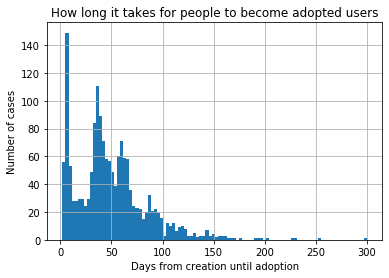

NameError: name 'time_to_adopt' is not defined

In [8]:
# Charting the time it takes for users to adopt the platform
df['time_to_adopt'] = (df['adoption_date']-df['creation_date'])
dtp = df.time_to_adopt.dt.days
dtp.hist(bins=100)
plt.title('How long it takes for people to become adopted users')
plt.xlabel('Days from creation until adoption')
plt.ylabel('Number of cases')
plt.style.use('classic')
plt.show()

# Calculating the mean for adoption time
print('The average time it takes to adopt the platform is {:.0f} days'.format(np.mean(time_to_adopt)))

In [ ]:
print('Most recent user created on {}'.format(df.creation_date.max()))
print('Last login recorded on {}'.format(df_engagement.date_visited.max()))
print('Users created after {} should be removed'.format(df_engagement.date_visited.max() - dt.timedelta(50)))

In [ ]:
# Make the data frame without censored cases
df = df[df.creation_date <= df_engagement.date_visited.max() - dt.timedelta(50)]
print('After removing the censored points, there were {} cases left.'.format(df_clean.shape[0]))

#### 2.1 Recoding & feature engineering

Before running the machine learning, we explored and recoded variables where appropriate, as noted below. For further details on these analyses, see the appendix (which contains my EDA).
1. Email provider. There were six main email providers with counts over 800, all others having 2 or less. The six main were kept, and the others were combined into one 'other' category.
2. Invited by user. About 1/3 of users had no invite, and no user gave more than 13 invites. This variable was recoded into an indicator variable (0 for no invitation, 1 for an invitation).
3. Organizational ID. There were 417 unique organizational IDs, and we have no further information on the nature, names or structure of these organizations. As such, we removed this ID from the machine learning model as it would be likely to cause issues with fitting and then still not be interpretable.

In [9]:
# Recode emails
df['email_provider'] = [x.split('@')[1] for x in df.email] #select out the domain
#df.email_provider.value_counts() # this shows that there are six main providers
top_emails = df.email_provider.value_counts().index[:6]

#label anything not in the top 6 as other
df['email_provider'] = [x if x in top_emails else 'other' for x in df.email_provider]

In [10]:
# Recoding invited_by_user_id into an indicator variable
df['invited_by_user_ind'] = df['invited_by_user_id'] > 0
df['invited_by_user_ind'] = df['invited_by_user_ind'].astype(int)

In [11]:
# Invitation inspection
#df.invited_by_user_id.fillna(0).value_counts()
# Org ID inspection
#df.org_id.value_counts()

#### 2.2 Feature selection
The problem of leakage seems large in this dataset. Specifically, our outcome variable is based on login dates, and hence these are associated with such variables as creation date and last session date. To include date-based variables in our model would, in this instance, inflate the accuracy of our model. Another way to put it is that we want to predict <b>future</b> adopted users, so putting in current usage data (e.g. last login) would not help us in our future prediction.
As such, we did not include creation date or last login date as predictors.

<b>This left us with 5 predictors:</b>
1. Creation source.
2. Mailing list opt-in
3. Marketing drip
4. Email type
5. Invitation by user

Creation source and email type were given dummy variables.

In [36]:
df_profiles.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [37]:
df.email_provider = df.email_provider.astype('category')
df.creation_source = df.creation_source.astype('category')

df.head()

,adopted_user,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date,adoption_date,time_to_adopt,email_provider,invited_by_user_ind
user_id,,,,,,,,,,,,,
1,0,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22,2014-04-22,None,NaT,yahoo.com,1
2,1,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2013-11-15,2014-03-31,2014-02-09,86 days,gustr.com,1
3,0,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19,2013-03-19,None,NaT,gustr.com,1
4,0,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-21,2013-05-22,None,NaT,yahoo.com,1
5,0,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-17,2013-01-22,None,NaT,yahoo.com,1


In [61]:
X = df[['invited_by_user_ind', 'enabled_for_marketing_drip', 
        'opted_in_to_mailing_list', 'creation_source',
        'email_provider']]
y = df[['adopted_user']]
X.head()

# Check the shapes are the same
print('features and predictors have same shape: {}'.format(X.shape[0] == y.shape[0]))

# Import things
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
# Split data sets first

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)
print('features and predictors in TRAINING set have same shape: {}'.format(Xtrain.shape[0] == ytrain.shape[0]))
print('features and predictors in TEST set have same shape: {}'.format(Xtest.shape[0] == ytest.shape[0]))

# Pre-processing the columns
cat_pipe = Pipeline(['ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')]) # Set up the ohe
cat_cols = ['RoofMatl', 'HouseStyle'] # Select columns
cat_transformers = [('cat', cat_pipe, cat_cols)] # Make transformer step
ct = ColumnTransformer(transformers=cat_transformers) # Make column transformer

# Apply it

# Run random forest

# Evaluate with permutation

# Get feature importances

#X.info()


features and predictors have same shape: True
features and predictors in TRAINING set have same shape: True
features and predictors in TEST set have same shape: True


TypeError: zip argument #2 must support iteration

In [210]:
X = pd.get_dummies(df, columns=['creation_source', 'email_provider'])
X = X[['invited_by_user_ind', 'enabled_for_marketing_drip', 
        'opted_in_to_mailing_list', 'creation_source_GUEST_INVITE',
        'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
        'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
        'email_provider_cuvox.de', 'email_provider_gmail.com',
        'email_provider_gustr.com', 'email_provider_hotmail.com',
        'email_provider_jourrapide.com', 'email_provider_other',
        'email_provider_yahoo.com']]
X.head()

,invited_by_user_ind,enabled_for_marketing_drip,opted_in_to_mailing_list,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_provider_cuvox.de,email_provider_gmail.com,email_provider_gustr.com,email_provider_hotmail.com,email_provider_jourrapide.com,email_provider_other,email_provider_yahoo.com
user_id,,,,,,,,,,,,,,,
2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [180]:
le_trans.head()

,creation_labels,email_labels
user_id,,
2,1,2
3,1,2
4,0,6
5,0,6
6,0,6


In [213]:
# Create feature matrix and outcome vector
X = df[['creation_labels', 'email_labels','invited_by_user_ind', 'enabled_for_marketing_drip', 
        'opted_in_to_mailing_list']]
y = df['adopted_user']

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

In [225]:
# Add some GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

ohe = OneHotEncoder()
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
pl = Pipeline([('one hot encode', ohe),
               ('Grid Search CV Random Forest', model)
              ])

pl.fit(Xtrain, ytrain)
pl.predict(Xtest)
# use CV to tune number of trees
#model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)



/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters were {'n_estimators': 100}
Best average precision was 0.5768840824602907


In [30]:
# This is Jeremy Howard's version but one is now implemented in SKLearn
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

perm_imp = permutation_importances()

TypeError: permutation_importances() missing 4 required positional arguments: 'rf', 'X_train', 'y_train', and 'metric'

In [29]:
from sklearn.inspection import permutation_importance
#result = permutation_importance(pl, Xtest, ytest, n_repeats=10,
#                                random_state=42, n_jobs=2)
#sorted_idx = result.importances_mean.argsort()

In [254]:
pl[0].get_feature_names(['creation_labels', 'email_labels','invited_by_user_ind', 'enabled_for_marketing_drip', 
        'opted_in_to_mailing_list'])

array(['creation_labels_0.0', 'creation_labels_1.0',
       'creation_labels_2.0', 'creation_labels_3.0',
       'creation_labels_4.0', 'email_labels_0.0', 'email_labels_1.0',
       'email_labels_2.0', 'email_labels_3.0', 'email_labels_4.0',
       'email_labels_5.0', 'email_labels_6.0', 'invited_by_user_ind_0.0',
       'invited_by_user_ind_1.0', 'enabled_for_marketing_drip_0.0',
       'enabled_for_marketing_drip_1.0', 'opted_in_to_mailing_list_0.0',
       'opted_in_to_mailing_list_1.0'], dtype=object)

In [260]:
for name, importance in zip(list(pl[0].get_feature_names[0]), model.best_estimator_.feature_importances_):
    print ('feature {} importance {}'.format(name, importance))
    #dir(model)
print(model.best_estimator_.feature_importances_)




TypeError: 'method' object is not subscriptable

In [216]:
# Initial attempt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

pl = Pipeline([('one hot encode', OneHotEncoder()),
               ('rf', RandomForestClassifier(random_state=10, class_weight='balanced'))
              ])

pl.fit(Xtrain, ytrain)
pl.predict()

/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('one hot encode',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='error', n_values=None,
                               sparse=True)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                          

In [211]:

# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters were {'n_estimators': 100}
Best average precision was 0.5770530584656979
Accuracy of test set was 0.612772427774962
              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1567
           1       0.25      0.45      0.32       406

    accuracy                           0.61      1973
   macro avg       0.54      0.55      0.53      1973
weighted avg       0.70      0.61      0.65      1973

enabled_for_marketing_drip            0.215250
opted_in_to_mailing_list              0.211674
email_provider_hotmail.com            0.093890
email_provider_yahoo.com              0.060310
creation_source_GUEST_INVITE          0.048721
email_provider_jourrapide.com         0.045851
email_provider_gmail.com              0.045282
email_provider_gustr.com              0.043898
creation_source_SIGNUP                0.041983
creation_source_PERSONAL_PROJECTS     0.041679
email_provider_other                  0.041600
email_provider_cuvox.de 

Future ideas
(Future analyses could investigate predictors of the length of time until adoption, rather than adopting the binary outcome requested in the problem statement.)


## Appendix A. EDA

Before conducting machine learning, each potential predictor was explored for its relationship with the outcome.

##### 2.2.1 Creation source. 
The number of adopted users differed by creation source (see graph below, $\chi^2$ = 41.28, $p$ < .0005). Those signing up due to a guest invitation or a personal project appear to be more likely to be an adopted user. 

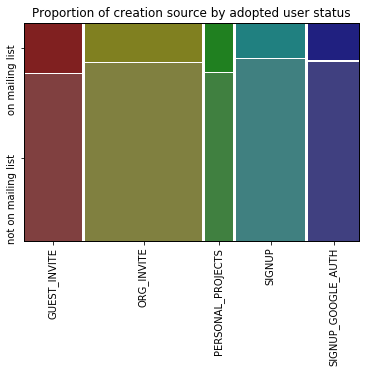

The χ-sq stat was 41.28 with p = 0.000000


In [164]:
from statsmodels.graphics.mosaicplot import mosaic

ct = pd.crosstab(df['creation_source'], df['adopted_user'])
ct.columns=['not on mailing list', 'on mailing list']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005], label_rotation=90,
       title='Proportion of creation source by adopted user status')
plt.show()

chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq stat was {:.2f} with p = {:6f}'.format(chisq, p))

##### 2.2.2 Mailing list opt-in

Mailing list opt-in does not appear to be associated with being an adopted user (see graph below, $\chi^2$ = 0.45, $p$ =.50)

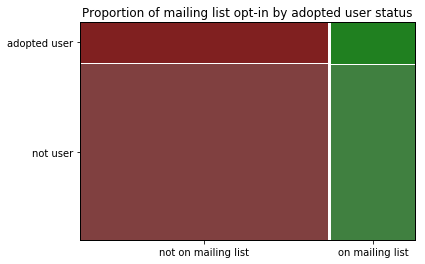

The χ-sq statistic was 0.45 with p = 0.50


In [145]:
ct = pd.crosstab(df['opted_in_to_mailing_list'], df['adopted_user'])
ct.columns = ['not user','adopted user']
ct.index=['not on mailing list', 'on mailing list']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of mailing list opt-in by adopted user status')
plt.show()

chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.2f}'.format(chisq, p))

##### 2.2.3 Marketing drip enabled
Marketing drip is not associated with being an adopted user (see graph below, $\chi^2$ = 0.13, $p$ =.72)

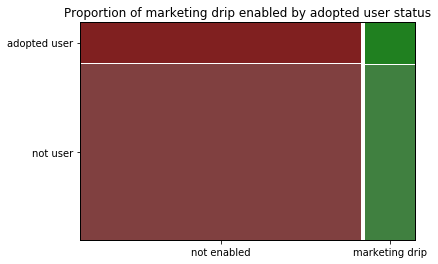

The χ-sq statistic was 0.13 with p = 0.72


In [153]:
ct = pd.crosstab(df['enabled_for_marketing_drip'], df['adopted_user'])
ct.columns = ['not user','adopted user']
ct.index=['not enabled', 'marketing drip']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of marketing drip enabled by adopted user status')
plt.show()

chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.2f}'.format(chisq, p))

##### 2.2.4 Invitation by current user
Being invited by a current user is associated with being an adopted user (see graph below, $\chi^2$ = 6.36, $p$ =.01)

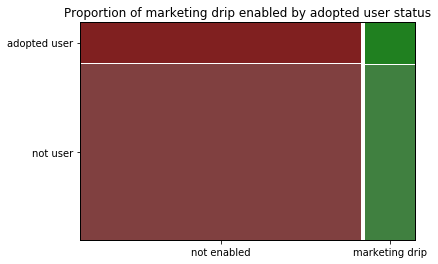

The χ-sq statistic was 0.13 with p = 0.72


In [162]:
ct = pd.crosstab(df['enabled_for_marketing_drip'], df['adopted_user'])
ct.columns = ['not user','adopted user']
ct.index=['not enabled', 'marketing drip']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of marketing drip enabled by adopted user status')
plt.show()

chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.2f}'.format(chisq, p))

##### 2.2.5 Email provider
Different email providers are associated with different levels of adopted users (see graph below, $\chi^2$ = 39.12, $p$ < 0.005). Hotmail users are most likely to be adopted users.

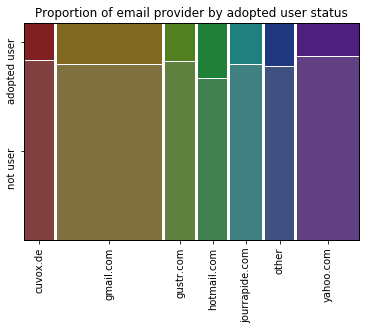

The χ-sq statistic was 39.12 with p = 0.0000007


In [163]:
ct = pd.crosstab(df['email_provider'], df['adopted_user'])
ct.columns = ['not user','adopted user']
mosaic(ct.stack(), labelizer = lambda x: "", gap=[0.01, 0.005],
       title='Proportion of email provider by adopted user status', label_rotation=90)
plt.show()

chisq, p, dof, efs = chi2_contingency(ct)
print('The \u03C7-sq statistic was {:.2f} with p = {:.7f}'.format(chisq, p))

##### 2.2.6 Creation date
Do a violin plot by type

##### 2.2.7 Last used date
Do a violin plot by type

In [252]:
df_profiles.iloc[11965:11970,:]

,object_id,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date
11965,11966,LuanaAzevedoFerreira@gmail.com,PERSONAL_PROJECTS,0,0,39,NaN,2013-01-01,NaT
11966,11967,PedroFernandesBarbosa@gmail.com,GUEST_INVITE,0,0,15,5688.0,2014-01-12,2014-05-31
11967,11968,MarcusMThorsen@gmail.com,SIGNUP_GOOGLE_AUTH,1,1,273,NaN,2013-04-01,2013-04-06
11968,11969,AidanDickinson@hotmail.com,GUEST_INVITE,1,1,52,6647.0,2013-06-01,2014-05-30
11969,11970,BrookeBartlett@gmail.com,SIGNUP,0,0,126,NaN,2013-10-19,NaT


In [253]:
df.iloc[11965:11970,:]

,adopted_user,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date,adoption_date,time_to_adopt,email_provider,invited_by_user_id_ind,creation_labels,email_labels,invited_by_user__ind,invited_by_user_ind
user_id,,,,,,,,,,,,,,,,,


In [265]:
df_engagement[df_engagement.user_id == 11969]

,user_id,visited,date_visited
207506,11969,1,2013-06-01
207507,11969,1,2013-06-02
207508,11969,1,2013-06-03
207509,11969,1,2013-06-13
207510,11969,1,2013-06-17
207511,11969,1,2013-07-04
207512,11969,1,2013-07-10
207513,11969,1,2013-07-20
207514,11969,1,2013-07-24
207515,11969,1,2013-07-27
